# ⚛️ H₃⁺ Excited States via SSVQE (Subspace-Search VQE)

This notebook computes the **ground state (E₀)** and **first excited state (E₁)**  
of the trihydrogen cation **H₃⁺** using the **SSVQE algorithm**.

SSVQE works by:

- Preparing two ansatz circuits, each with its own parameter set  
- Minimising:

\[
  C = E_0 + E_1 + \lambda \langle \psi_0 | \psi_1 \rangle
\]

where the penalty term enforces orthogonality of the states.

---

## 🔧 Simulation Setup

- Ansatz: **UCC singles + doubles**  
- Optimizer: **Adam**  
- Device: **default.qubit** (noiseless)  
- Output:
  - Convergence curves for \(E_0\) and \(E_1\)  
  - Final excitation energy \( \Delta E = E_1 - E_0 \)  
  - Basis-state amplitudes for both states  

This complements:
- `H3plus/Noiseless.ipynb`  
- `H3plus/Mapping_Comparison.ipynb`  
- `H3plus/Noise_Scan.ipynb`

by adding **excited-state capability** to your H₃⁺ notebook set.

In [1]:
# Core imports
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os, json, time
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Local utilities
from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    ensure_dirs,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    build_run_filename,
)

ensure_dirs()

# 🧬 Part 1 — H₃⁺ Molecular Setup

- Geometry: symmetric triangular H₃⁺  
- Basis: STO-3G  
- Charge: +1  
- Electrons: 2  

We also generate:
- Molecular Hamiltonian  
- Hartree–Fock reference  
- UCC singles + doubles excitations

In [2]:
seed = 0
set_seed(seed)

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000],
])
basis = "STO-3G"
electrons = 2

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=+1, basis=basis
)
hf = qchem.hf_state(electrons, qubits)

num_wires = qubits
print(f"H₃⁺ → {num_wires} qubits")

# Excitations
singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]

n_params = len(singles) + len(doubles)
print(f"Singles: {len(singles)}, Doubles: {len(doubles)}, Total params: {n_params}")

H₃⁺ → 6 qubits
Singles: 4, Doubles: 4, Total params: 8


# 🧱 Part 2 — SSVQE QNodes

We need:

### 1. State preparation circuit  
A standard UCC singles+doubles ansatz.

### 2. Energy QNode  
\[
E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
\]

### 3. Overlap QNode between two parameter sets  
\[
\langle \psi(\theta_0) | \psi(\theta_1) \rangle
\]

The penalty term enforces approximate orthogonality.

In [3]:
dev = qml.device("default.qubit", wires=num_wires)

def state_circuit(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
    )

@qml.qnode(dev)
def energy_expectation(params):
    state_circuit(params)
    return qml.expval(hamiltonian)

@qml.qnode(dev)
def overlap(params0, params1):
    # Prepare ψ0
    excitation_ansatz(params0, wires=range(num_wires),
                      hf_state=hf, excitations=(singles, doubles))
    # Apply adjoint of ψ1
    qml.adjoint(state_circuit)(params1)
    return qml.probs(wires=range(num_wires))

def overlap00(p0, p1):
    return overlap(p0, p1)[0]  # Probability of |00...0>

# 💾 Part 3 — Cache-Aware SSVQE Driver

We optimise both parameter sets simultaneously:

\[
C = E_0 + E_1 + \lambda \langle \psi_0 | \psi_1 \rangle
\]

and store:

- Energy trajectories  
- Final parameters  
- Metadata / reproducibility info  

In [4]:
def run_ssvqe_with_cache(stepsize=0.4, max_iter=75, penalty_weight=10.0):
    ansatz_desc = "SSVQE UCC singles+doubles"
    optimizer_name = "Adam"

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=seed,
    )
    cfg["penalty_weight"] = float(penalty_weight)

    sig = run_signature(cfg)
    fname = build_run_filename("H3plus_SSVQE", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    # Load cached run if present
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] loaded {existing}")
        return {
            "E0_list": rec["E0_list"],
            "E1_list": rec["E1_list"],
            "final_params": np.array(rec["final_params"]),
        }

    # Cost function for joint optimisation
    def ssvqe_cost(params):
        p0 = params[:n_params]
        p1 = params[n_params:]
        E0 = energy_expectation(p0)
        E1 = energy_expectation(p1)
        penalty = penalty_weight * overlap00(p0, p1)
        return E0 + E1 + penalty

    params = np.zeros(2 * n_params, requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    E0_list, E1_list = [], []

    for _ in range(max_iter):
        params, _ = opt.step_and_cost(ssvqe_cost, params)
        p0, p1 = params[:n_params], params[n_params:]
        E0_list.append(float(energy_expectation(p0)))
        E1_list.append(float(energy_expectation(p1)))

    # Save record
    run_record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3plus",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": num_wires,
        "algorithm": "SSVQE",
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iter,
            "iterations_ran": len(E0_list),
        },
        "seed": seed,
        "penalty_weight": penalty_weight,
        "E0_list": E0_list,
        "E1_list": E1_list,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
    }

    save_run_record(fname, run_record)
    print(f"[saved] {fname}")

    return {"E0_list": E0_list, "E1_list": E1_list, "final_params": params}

# 🚀 Part 4 — Run SSVQE

In [5]:
res = run_ssvqe_with_cache(
    stepsize=0.4,
    max_iter=100,
    penalty_weight=10.0,
)

E0_list = res["E0_list"]
E1_list = res["E1_list"]
params = res["final_params"]

[reuse] loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_SSVQE_Adam_s0__ee06aabee587.json


# 📉 Part 5 — Energy Convergence

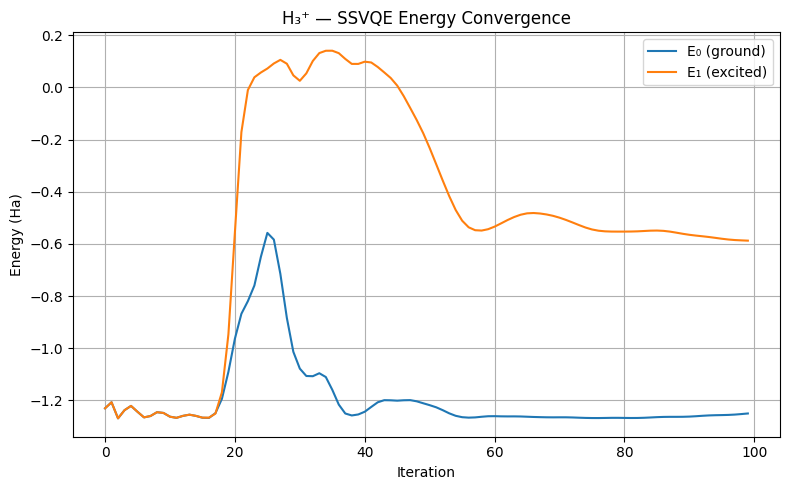

In [6]:
plt.figure(figsize=(8,5))
plt.plot(E0_list, label="E₀ (ground)")
plt.plot(E1_list, label="E₁ (excited)")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ — SSVQE Energy Convergence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_SSVQE_Adam.png", dpi=300)
plt.show()

# 📊 Part 6 — Final Energies & Excitation Gap

In [7]:
final_E0 = E0_list[-1]
final_E1 = E1_list[-1]
delta_E = final_E1 - final_E0

print(f"E₀ = {final_E0:.8f} Ha")
print(f"E₁ = {final_E1:.8f} Ha")
print(f"ΔE = {delta_E:.8f} Ha")

E₀ = -1.25054229 Ha
E₁ = -0.58759689 Ha
ΔE = 0.66294540 Ha


# 🔍 Part 7 — Statevector Comparison

We extract |ψ₀⟩ and |ψ₁⟩ and compare basis-state amplitudes.

Only amplitudes above **1e-2** are shown to keep the plot readable.

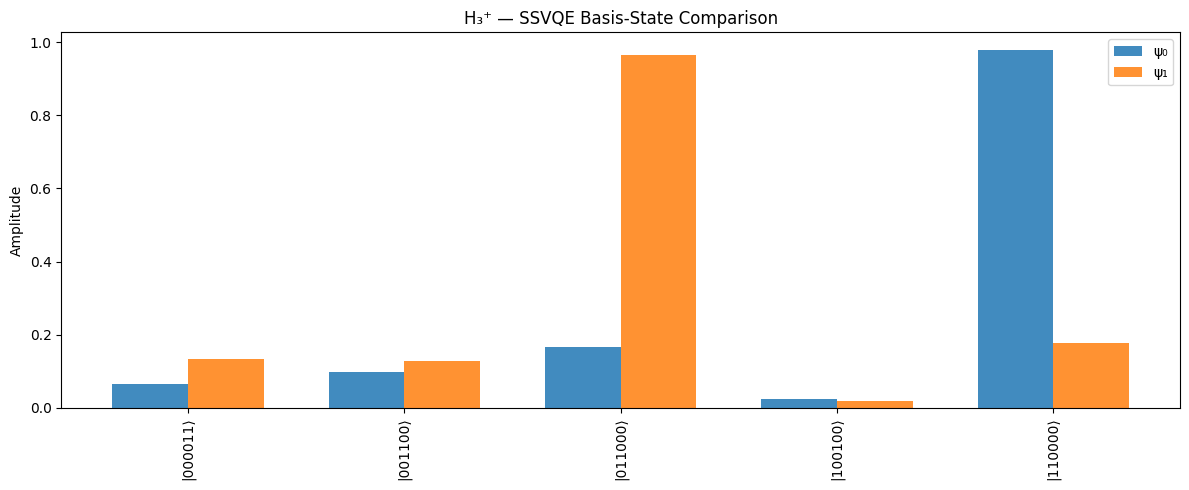

In [8]:
@qml.qnode(dev)
def get_state(params):
    excitation_ansatz(params, wires=range(num_wires),
                      hf_state=hf, excitations=(singles, doubles))
    return qml.state()

psi_0 = get_state(params[:n_params])
psi_1 = get_state(params[n_params:])

threshold = 1e-2
indices = np.unique(np.where(
    (np.abs(psi_0) > threshold) | (np.abs(psi_1) > threshold)
)[0])

labels = [f"|{i:0{num_wires}b}⟩" for i in indices]
amp0 = np.abs([psi_0[i] for i in indices])
amp1 = np.abs([psi_1[i] for i in indices])

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, amp0, width, alpha=0.85, label="ψ₀")
plt.bar(x + width/2, amp1, width, alpha=0.85, label="ψ₁")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Amplitude")
plt.title("H₃⁺ — SSVQE Basis-State Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_SSVQE_State_Comparison.png", dpi=300)
plt.show()